In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import os
from src import data
import json
from tqdm.auto import tqdm
from src.metrics import AggregateMetric
import logging
import torch
import json

from src.utils import logging_utils
from src.utils.sweep_utils import read_sweep_results, relation_from_dict


# logging_utils.configure(level=logging.DEBUG)


In [3]:
############################################
sweep_root = "../../results/sweep-full-rank"
model_name = "gptj"
############################################

sweep_path = f"{sweep_root}/{model_name}"

In [4]:
sweep_results = read_sweep_results(sweep_path)

for relation in sweep_results:
    print(relation, end=": ")
    print(len(sweep_results[relation]["trials"]))

person occupation: 20
landmark in country: 20
country capital city: 23
plays pro sport: 20
person plays instrument: 20
person university: 20
city in country: 20
food from country: 20
company hq: 20
country language: 20
superhero archnemesis: 18
landmark on continent: 20
person lead singer of band: 5
country largest city: 20
country currency: 20
star constellation name: 20
pokemon evolution: 20
product by company: 20
superhero person: 20
person sport position: 20


In [35]:
def rankwise_performance(relation_result):
    rank_recalls = {beta.rank: [] for beta in relation_result.trials[0].layers[0].result.betas}
    rank_efficacies = {rank.rank: [] for rank in relation_result.trials[0].layers[0].result.ranks}

    for trial in relation_result.trials:
        for beta in trial.layers[0].result.betas:
            rank_recalls[beta.rank].append(beta.recall[0])
        for rank in trial.layers[0].result.ranks:
            rank_efficacies[rank.rank].append(rank.efficacy[0])
    
    ranks = list(rank_recalls.keys())

    return ranks, list(rank_recalls.values()), list(rank_efficacies.values())


In [6]:
import pandas as pd

df = pd.read_csv("../../results/tables/gptj-hparams.csv")

In [7]:
relation_dict = {}
for relation in tqdm(sweep_results):
    relation_dict[relation] = relation_from_dict(sweep_results[relation])

  0%|          | 0/20 [00:00<?, ?it/s]

In [71]:
#########################################
tau = 0.7
#########################################

F = None
C = None

for relation in relation_dict:
    res = df[df["relation"] == relation].to_dict(orient="records")[0]
    print(f"{relation} >> faithfulness={res['recall@1']} | efficacy={res['efficacy']}")
    if float(res['recall@1'].split()[0]) > tau:
        ranks, faithfulness, efficacies = rankwise_performance(relation_dict[relation])
        F = torch.Tensor(faithfulness).T if F is None else torch.cat([F, torch.Tensor(faithfulness).T], dim=0)
        C = torch.Tensor(efficacies).T if C is None else torch.cat([C, torch.Tensor(efficacies).T], dim=0)

print(F.shape)

f_mean = F.mean(dim = 0)
c_mean = C.mean(dim = 0)
f_std = F.std(dim = 0)
c_std = C.std(dim = 0)

person occupation >> faithfulness= 0.52 ±  0.08 | efficacy= 0.71 ±  0.04
landmark in country >> faithfulness= 0.24 ±  0.04 | efficacy= 0.71 ±  0.01
country capital city >> faithfulness= 0.85 ±  0.08 | efficacy= 0.97 ±  0.04
plays pro sport >> faithfulness= 0.83 ±  0.05 | efficacy= 0.94 ±  0.01
person plays instrument >> faithfulness= 0.57 ±  0.09 | efficacy= 0.69 ±  0.04
person university >> faithfulness= 0.63 ±  0.09 | efficacy= 0.94 ±  0.05
city in country >> faithfulness= 0.58 ±  0.06 | efficacy= 0.96 ±  0.05
food from country >> faithfulness= 0.55 ±  0.12 | efficacy= 0.96 ±  0.05
company hq >> faithfulness= 0.21 ±  0.05 | efficacy= 0.53 ±  0.03
country language >> faithfulness= 0.89 ±  0.08 | efficacy= 0.99 ±  0.03
superhero archnemesis >> faithfulness= 0.29 ±  0.09 | efficacy= 0.62 ±  0.15
landmark on continent >> faithfulness= 0.76 ±  0.10 | efficacy= 0.93 ±  0.02
person lead singer of band >> faithfulness= 0.55 ±  0.18 | efficacy= 0.85 ±  0.08
country largest city >> faithfulnes

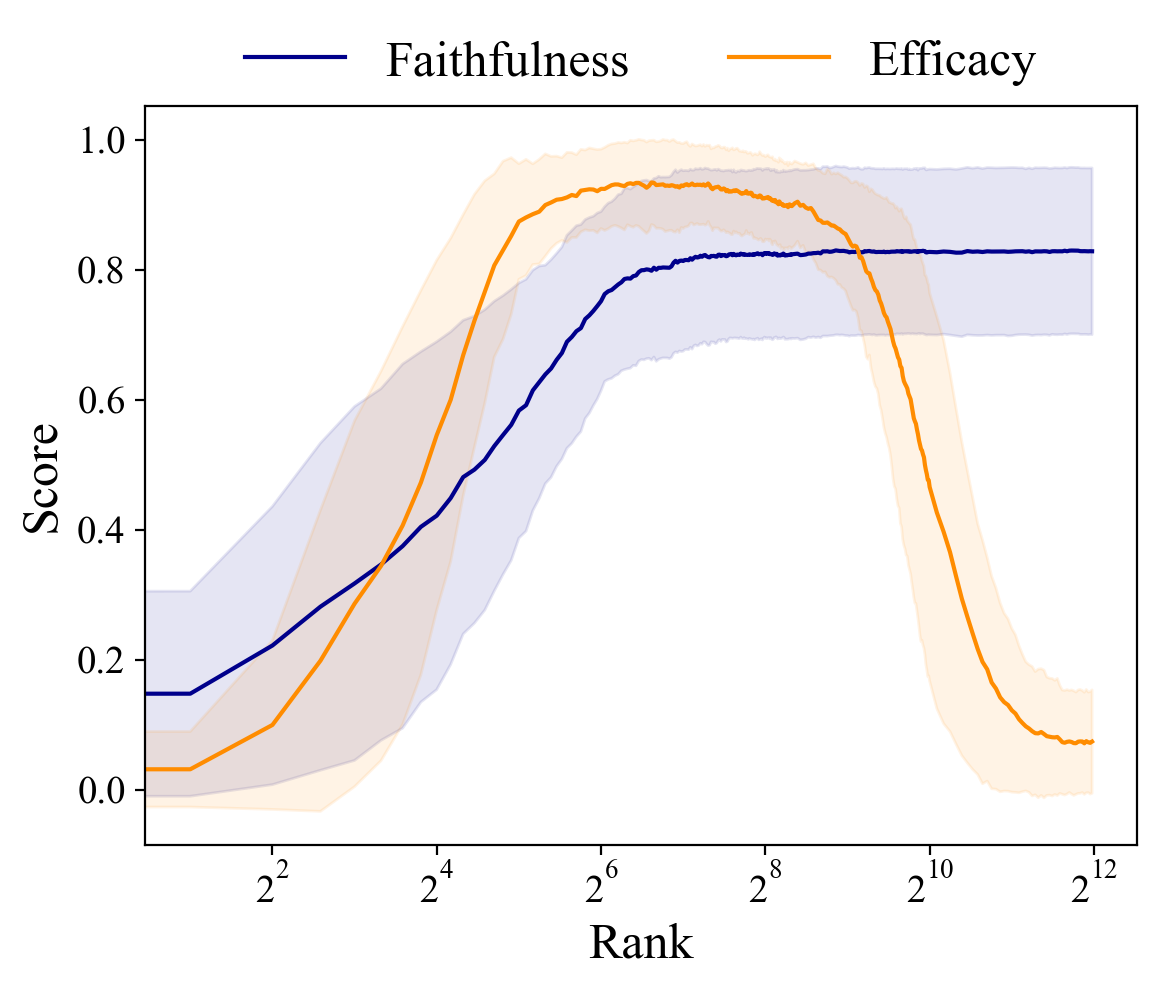

In [80]:
plt.rcdefaults()
fig_dir = "figs"
#####################################################################################
plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=50)  # fontsize of the figure title


faith_color = "darkblue"
cause_color = "darkorange"
#####################################################################################

plt.plot(ranks, f_mean, label = "Faithfulness", color = faith_color, linewidth = 1.5)
plt.fill_between(ranks, f_mean - f_std, f_mean + f_std, alpha = 0.1, color = faith_color)
plt.plot(ranks, c_mean, label = "Efficacy", color = cause_color, linewidth = 1.5)
plt.fill_between(ranks, c_mean - c_std, c_mean + c_std, alpha = 0.1, color = cause_color)

plt.xscale("log", base = 2)
plt.xlabel("Rank")
plt.ylabel("Score")
plt.legend(ncol = 2, bbox_to_anchor=(0.5, 1.15), loc='upper center', frameon=False)

plt.savefig(f"{fig_dir}/rank-sweep.pdf", bbox_inches="tight")
plt.show()